## Importing the required modules

We'll be using Keras' Functional API's which is created on top of Tensorflow to model our classifier.

In [9]:
import tensorflow as tf
from tensorflow import keras
from ipywidgets import FileUpload
from keras.preprocessing import image
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os 
import io

## Preparing the data

We'll load the image dataset from directory. 

In [10]:
batch_size =32

train_ds = keras.preprocessing.image_dataset_from_directory(
    directory=os.path.join("data","train"),
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224))
validation_ds = keras.preprocessing.image_dataset_from_directory(
    directory=os.path.join("data","valid"),
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224))
test_ds = keras.preprocessing.image_dataset_from_directory(
    directory=os.path.join("data","test"),
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224))

Found 10500 files belonging to 7 classes.
Found 3500 files belonging to 7 classes.
Found 2249 files belonging to 7 classes.


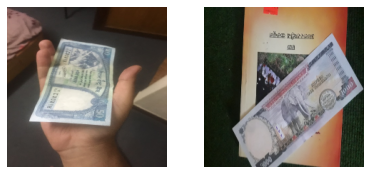

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(2):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

### Loading the pre-trained VGG model

Freezing the weights of Covolution layers and making the fully connected layers to be trainable

In [12]:
pre_trained_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(7, activation='softmax')(x)

## Fitting the model


In [14]:
model = tf.keras.Model(pre_trained_model.input, x)
model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['acc'])

In [15]:
curr_classifier = model.fit(
    train_ds,
    epochs = 10,
    validation_data=validation_ds,
    batch_size = batch_size,
    verbose = 1
)

Epoch 1/10


2022-04-22 12:42:27.462542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


329/329 [==============================] - ETA: 0s - loss: 4.5404 - acc: 0.7583

2022-04-22 12:44:02.552102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


329/329 [==============================] - 126s 380ms/step - loss: 4.5404 - acc: 0.7583 - val_loss: 1.0791 - val_acc: 0.8329
Epoch 2/10
329/329 [==============================] - 126s 382ms/step - loss: 0.5929 - acc: 0.8864 - val_loss: 0.6828 - val_acc: 0.8800
Epoch 3/10
329/329 [==============================] - 125s 379ms/step - loss: 0.3556 - acc: 0.9124 - val_loss: 0.5960 - val_acc: 0.8889
Epoch 4/10
329/329 [==============================] - 125s 379ms/step - loss: 0.3017 - acc: 0.9267 - val_loss: 0.6708 - val_acc: 0.8749
Epoch 5/10
329/329 [==============================] - 125s 380ms/step - loss: 0.2310 - acc: 0.9410 - val_loss: 0.6362 - val_acc: 0.8906
Epoch 6/10
329/329 [==============================] - 125s 380ms/step - loss: 0.2105 - acc: 0.9461 - val_loss: 0.6670 - val_acc: 0.8786
Epoch 7/10
329/329 [==============================] - 147s 446ms/step - loss: 0.1948 - acc: 0.9473 - val_loss: 0.6508 - val_acc: 0.8966
Epoch 8/10
329/329 [==============================] - 146s 

In [16]:
model.save("currency_5_ep.h5")

## Loading the trained model

In [17]:
model = load_model('currency_5_ep.h5')

In [18]:
uploader = FileUpload()
uploader

FileUpload(value={}, description='Upload')

In [19]:
for name, file_info in uploader.value.items():
    img = Image.open(io.BytesIO(file_info['content']))

type(img)
img = img.resize((224, 224), Image.ANTIALIAS)
i = np.array(img)
x = np.expand_dims(i, axis=0)
x.shape

/var/folders/sm/nk9rt9dn17j6zsk2rg9x2s5m0000gn/T/ipykernel_18982/3488905702.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((224, 224), Image.ANTIALIAS)


(1, 224, 224, 3)

In [20]:
class_labels = ['fifty', 'five', 'fivehundred', 'hundred','ten','thousand', 'twenty']
y_prob = model.predict(x) 
y_classes = y_prob.argmax(axis=-1)
class_labels[y_classes[0]]

2022-04-22 13:11:24.116924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


'ten'

In [21]:
result = model.evaluate(test_ds,batch_size=batch_size)
print("test_loss, test accuracy",result)

2022-04-22 13:11:27.580618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


71/71 [==============================] - 26s 318ms/step - loss: 1.1639 - acc: 0.8542
test_loss, test accuracy [1.163852572441101, 0.8541573882102966]


Hence we conclude the basic implementation.

## Updates to follow

* More Analytics on the output
* Served and deployed with FastAPI